# OpenHAP Measurement Normalization Framework

![title](../../images/chamberTest.png)

## Import required libraries

In [1]:
import os
import csv
import time
import glob
import datetime
import pandas as pd
import paho.mqtt.client as mqtt
from matplotlib import pyplot as plt
from IPython.display import clear_output

## Setup defaults

### Setup broker specifics

In [2]:
broker_address = "127.0.0.1"

In [3]:
broker_qos, command_qos, measurement_qos = 2,2,2

In [4]:
command_interval = 5

In [5]:
openhap_units = 0

In [6]:
system_mid, command_mid, measurement_mid = 0,0,0

### Setup dataframe and file specifics

In [7]:
time_field_txt = "Message received time (UTC)"
device_field_txt = "Device"
device_time_field_txt = "Device time (UTC)"
measurement_field_txt = "Particulate measurement"
connected_openhap_units_field_txt = "Connected OpenHAP units"

In [8]:
csv_fieldnames = [time_field_txt, device_field_txt, device_time_field_txt, 
                  measurement_field_txt, connected_openhap_units_field_txt]

In [9]:
measurement_filename = "chamberTest.csv"
client_metadata_file = "broker.csv"

## Setup dataframes and the live plotting function

In [10]:
measurement_df = pd.DataFrame(columns=csv_fieldnames)

measurement_df[measurement_field_txt]= measurement_df[measurement_field_txt].astype(int)
measurement_df[device_time_field_txt]= measurement_df[device_time_field_txt].astype('datetime64[ns]')

In [11]:
%matplotlib inline

def live_plot():
    measurement_df_copy = measurement_df.copy()
    measurement_df_copy[measurement_field_txt]= measurement_df_copy[measurement_field_txt].astype(int)
    measurement_df_copy.set_index(device_time_field_txt, inplace=True)
    measurement_df_copy.groupby(device_field_txt)[measurement_field_txt].plot(legend=True, 
                                                                              figsize=(20,10), 
                                                                              grid=True)
    clear_output(wait=True)
    plt.show();

## Setup event callbacks

In [12]:
def on_connect(client, userdata, flags, rc):
    global system_mid, command_mid, measurement_mid
    if rc == 0:
        print("Connected OK")
        system_mid = client.subscribe("$SYS/broker/clients/#", broker_qos)[-1]
        command_mid = client.subscribe("command", command_qos)[-1]
        measurement_mid = client.subscribe("measurement/#", measurement_qos)[-1]

In [13]:
def on_subscribe(client, userdata, mid, granted_qos): 
    if mid == measurement_mid:
        print("measurement topics successfully subscribed")
    elif mid == command_mid:
        print("Command topic successfully subscribed")
    elif mid == system_mid:
        print("System topic successfully subscribed")
    else:
        print("Other topic subscription acknowledgement received")

In [14]:
def on_message(client, userdata, message):
    global openhap_units, measurement_df
    if message.topic == "command":
        print("Measurement command sent!")
    if "measurement" in message.topic:
            message_received_time = datetime.datetime.utcnow()
            mqtt_topic_levels = message.topic.split('/')
            if len(mqtt_topic_levels) != 2:
                print("Improperly formatted measurement topic received")
            else:
                payload = str(message.payload, 'utf-8').split(',')\
                
                device = mqtt_topic_levels[1]
                device_time = int(payload[1])
                measurement = int(payload[0])
                
                #Not ideal to expand a dataframe...but it will do
                temp = pd.DataFrame([[message_received_time,device,
                                      device_time, measurement, openhap_units]], 
                                    columns = csv_fieldnames)
                
                temp[device_time_field_txt] = pd.to_datetime(temp[device_time_field_txt], unit='s')
                measurement_df = pd.concat([measurement_df, temp])
                live_plot()
    if "connected" in message.topic:
        connected_clients = int(str(message.payload, 'utf-8'))
        openhap_units = connected_clients - 1
        print(f"{openhap_units} OpenHAP units connected to broker")

## Test code

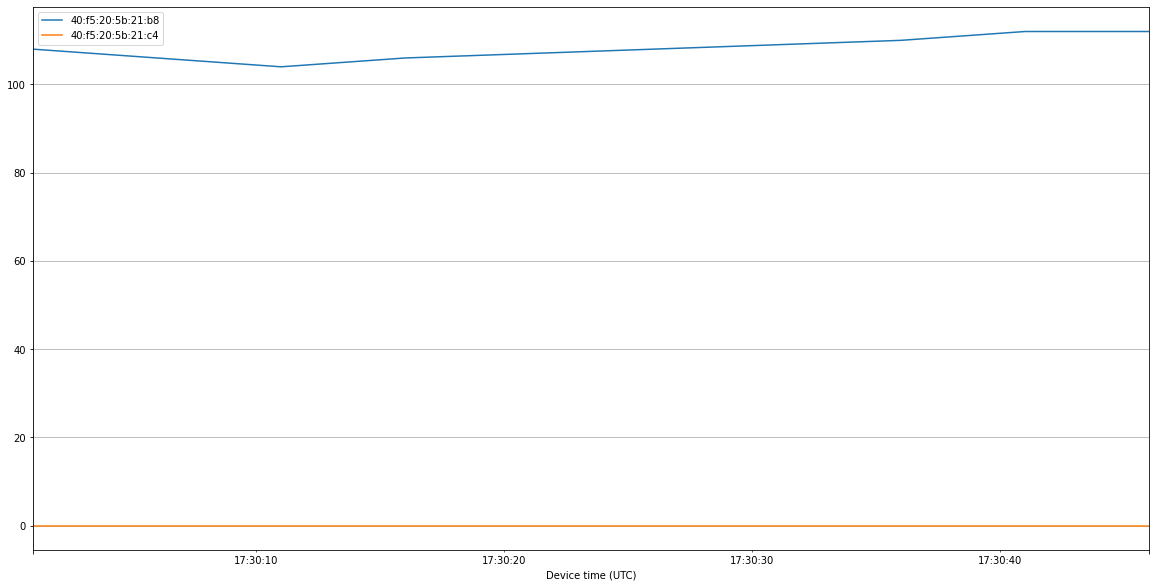

Measurement command sent!
Event loop thread stopped and CSV written
End of program


In [15]:
file_present = glob.glob(measurement_filename)

if file_present:
    os.remove(measurement_filename)

controller = mqtt.Client("controller",clean_session=True)

controller.on_connect = on_connect
controller.on_subscribe = on_subscribe
controller.on_message = on_message

controller.connect(broker_address)
controller.loop_start()

while True:
    try:
        time.sleep(command_interval)
        controller.publish("command", "measure")
    except KeyboardInterrupt:
        controller.loop_stop()
        controller.disconnect()
        measurement_df.to_csv(measurement_filename, encoding = "utf-8", index = False)
        print("Event loop thread stopped and CSV written")
        break
print("End of program")